In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data
#import torchvision.transforms as transforms


In [2]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()
    
def addNoise(shape, noise=0.1):
    #print(shape)
    return Variable(torch.zeros(shape).normal_(0, noise).cuda())

In [3]:
batch_size = 5

images = np.load('padded_gray_chair_imgs.npy')
images[:] *= 1/images[:].max()#(images[:] - np.mean(images[:])) / np.std(images[:])
voxels = np.load('chair_voxels.npy')
print(images[1:1316].shape)
print(images[1316:1416].shape)
train_images = images[1:1316]
val_images = images[1316:1416]
train_voxels = voxels[1:1316]
val_voxels = voxels[1316:1416]

(1315, 128, 128)
(100, 128, 128)


Displaying the object


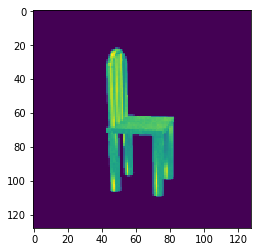

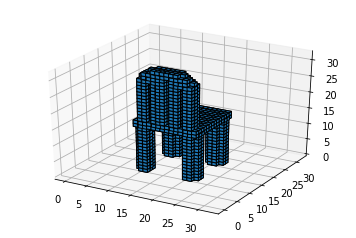

In [4]:
display_id = 56

train_data = [train_voxels, train_images]
for _ in range(len(train_data)):
    train_data[_] = torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    train_data[_] = train_data[_].cuda()
train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))] 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)
plt.imshow(train_images[display_id])
display3DObject(train_voxels[display_id])

In [ ]:
display3DObject(voxels[877])

In [5]:
class VAE(nn.Module):
    def __init__(self, input_nc=1, z_size=200, ndf=25, cube_size=32):
        super(VAE, self).__init__()
        self.encoderLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.encoderLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.encoderLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.encoderLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.fc1 = nn.Linear(ndf*8, self.z_size)
        self.fc2 = nn.Linear(ndf*8, self.z_size)
        
        self.decoderLayer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.decoderLayer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.decoderLayer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.decoderLayer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def encoder(self, x): 
        out = self.encoderLayer1(x)
        out = self.encoderLayer2(out)
        out = self.encoderLayer3(out)
        out = self.encoderLayer4(out)
        out = self.encoderLayer5(out)
        out = self.encoderLayer6(out).view(-1, self.z_size)
        return self.fc1(out), self.fc2(out)
    
    #source: https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, x):
        out = self.decoderLayer1(x)
        out = self.decoderLayer2(out)
        out = self.decoderLayer3(out)
        out = self.decoderLayer4(out)
        return out
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        latent = self.reparametrize(mu,sigma)
        latent = latent.view(-1,self.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        
        object_3D = self.decoder(latent)
        return object_3D, mu, sigma
        

In [6]:
vae = VAE().cuda()

In [7]:
lr_vae = 0.0003
lr_d = 0.001
adam_beta_vae = (0.5, 0.5)
adam_beta_d = (0.5, 0.5)
vae_solver = optim.Adam(vae.parameters(), lr=lr_vae, betas = adam_beta_vae)

In [12]:
#Training the system
num_epochs = 500
val_images = torch.FloatTensor(val_images)
val_voxels = torch.FloatTensor(val_voxels)
loss = nn.BCELoss(size_average=False)
for epoch in range(num_epochs):
    vae_losses = []
    klds = []
    for batch_idx, (data3d, data2d) in enumerate(train_loader):
        var_3D_data = Variable(data3d).cuda().float()
        var_2D_data = Variable(data2d).cuda().float().unsqueeze(1)
        generated_object, mu, logvar = vae(var_2D_data)
        generated_object= generated_object.squeeze()
            # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#         KLD_element = mu.pow(2).add_(sigma.exp()).mul_(-1).add_(1).add_(sigma)
#         KLD = torch.sum(KLD_element).mul_(-0.5)
        # https://arxiv.org/abs/1312.6114
        #print(logvar.shape)
        KLD =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        #rint(KLD)
        loss_ = loss(generated_object, var_3D_data) + KLD
        vae.zero_grad()
        loss_.backward()
        vae_solver.step()
        vae_losses.append(loss_)
        klds.append(KLD)
    val_3D_data = Variable(val_voxels).cuda().float()
    val_2D_data = Variable(val_images).cuda().float().unsqueeze(1)
    generated_object_val, mu, sigma = vae(val_2D_data)
    generated_object_val = torch.round(generated_object_val.squeeze())
    accuracy = np.mean((generated_object_val  == val_3D_data).squeeze().data.cpu().numpy())
    vae_losses_mean = np.mean(np.concatenate(vae_losses))
    kld_mean =  np.mean(np.concatenate(klds)).data.cpu().numpy()[0]
    print("Epoch: ", epoch, '\n', "VAE loss: ", vae_losses_mean.data.cpu().numpy()[0])
    print("Accuracy", accuracy, "KLD loss: ", kld_mean)

Epoch:  0 
 VAE loss:  4330.482
Accuracy 0.9420913696289063 KLD loss:  1024.8699
Epoch:  1 
 VAE loss:  4333.957
Accuracy 0.9441250610351563 KLD loss:  1027.5842
Epoch:  2 
 VAE loss:  4266.849
Accuracy 0.9438662719726563 KLD loss:  1025.8873
Epoch:  3 
 VAE loss:  4281.753
Accuracy 0.9434326171875 KLD loss:  1034.9482
Epoch:  4 
 VAE loss:  4237.5327
Accuracy 0.9430105590820312 KLD loss:  1033.2355
Epoch:  5 
 VAE loss:  4193.819
Accuracy 0.9438986206054687 KLD loss:  1038.8722
Epoch:  6 
 VAE loss:  4202.245
Accuracy 0.9432952880859375 KLD loss:  1039.103
Epoch:  7 
 VAE loss:  4175.4673
Accuracy 0.9438677978515625 KLD loss:  1040.2294
Epoch:  8 
 VAE loss:  4141.003
Accuracy 0.9430270385742188 KLD loss:  1043.2289
Epoch:  9 
 VAE loss:  4100.757
Accuracy 0.9436505126953125 KLD loss:  1041.389
Epoch:  10 
 VAE loss:  4084.107
Accuracy 0.9427566528320312 KLD loss:  1041.4536
Epoch:  11 
 VAE loss:  4090.5066
Accuracy 0.9434967041015625 KLD loss:  1046.2611
Epoch:  12 
 VAE loss:  4046

Epoch:  100 
 VAE loss:  2912.155
Accuracy 0.9437530517578125 KLD loss:  1073.476
Epoch:  101 
 VAE loss:  2887.694
Accuracy 0.942686767578125 KLD loss:  1075.934
Epoch:  102 
 VAE loss:  2863.5854
Accuracy 0.9437451171875 KLD loss:  1071.7302
Epoch:  103 
 VAE loss:  2879.537
Accuracy 0.9435263061523438 KLD loss:  1073.038
Epoch:  104 
 VAE loss:  2877.1848
Accuracy 0.942427978515625 KLD loss:  1071.7478
Epoch:  105 
 VAE loss:  2843.633
Accuracy 0.9429293823242187 KLD loss:  1072.4767
Epoch:  106 
 VAE loss:  2840.7297
Accuracy 0.943526611328125 KLD loss:  1067.4718
Epoch:  107 
 VAE loss:  2843.9004
Accuracy 0.94305908203125 KLD loss:  1078.8094
Epoch:  108 
 VAE loss:  2821.7175
Accuracy 0.9418115234375 KLD loss:  1075.443
Epoch:  109 
 VAE loss:  2825.953
Accuracy 0.94189208984375 KLD loss:  1071.9132
Epoch:  110 
 VAE loss:  2820.8162
Accuracy 0.9432196044921874 KLD loss:  1076.0216
Epoch:  111 
 VAE loss:  2806.3064
Accuracy 0.9425201416015625 KLD loss:  1073.4836
Epoch:  112 
 

Epoch:  199 
 VAE loss:  2313.886
Accuracy 0.94221435546875 KLD loss:  1071.3057
Epoch:  200 
 VAE loss:  2291.6858
Accuracy 0.9429287719726562 KLD loss:  1066.778
Epoch:  201 
 VAE loss:  2276.8506
Accuracy 0.9427023315429688 KLD loss:  1066.5417
Epoch:  202 
 VAE loss:  2294.4468
Accuracy 0.9425747680664063 KLD loss:  1068.6417
Epoch:  203 
 VAE loss:  2272.2058
Accuracy 0.9423812866210938 KLD loss:  1065.1531
Epoch:  204 
 VAE loss:  2270.6191
Accuracy 0.942200927734375 KLD loss:  1065.0957
Epoch:  205 
 VAE loss:  2271.2812
Accuracy 0.9424392700195312 KLD loss:  1066.7668
Epoch:  206 
 VAE loss:  2255.7585
Accuracy 0.9417758178710938 KLD loss:  1060.1953
Epoch:  207 
 VAE loss:  2271.4602
Accuracy 0.9415780639648438 KLD loss:  1064.5409
Epoch:  208 
 VAE loss:  2249.1646
Accuracy 0.9428350830078125 KLD loss:  1064.9625
Epoch:  209 
 VAE loss:  2262.6438
Accuracy 0.9427462768554687 KLD loss:  1063.4152
Epoch:  210 
 VAE loss:  2256.9695
Accuracy 0.9424478149414063 KLD loss:  1070.84

Epoch:  298 
 VAE loss:  1981.7008
Accuracy 0.942879638671875 KLD loss:  1051.7416
Epoch:  299 
 VAE loss:  1986.2998
Accuracy 0.94218994140625 KLD loss:  1043.8575
Epoch:  300 
 VAE loss:  1961.0625
Accuracy 0.9424203491210937 KLD loss:  1046.4413
Epoch:  301 
 VAE loss:  1977.7688
Accuracy 0.9429476928710937 KLD loss:  1046.8632
Epoch:  302 
 VAE loss:  1960.0768
Accuracy 0.9418966674804687 KLD loss:  1045.7737
Epoch:  303 
 VAE loss:  1960.9004
Accuracy 0.9425823974609375 KLD loss:  1045.2834
Epoch:  304 
 VAE loss:  1957.868
Accuracy 0.9419821166992187 KLD loss:  1039.0983
Epoch:  305 
 VAE loss:  1961.2357
Accuracy 0.9419537353515625 KLD loss:  1041.038
Epoch:  306 
 VAE loss:  1941.9172
Accuracy 0.9421975708007813 KLD loss:  1040.3759
Epoch:  307 
 VAE loss:  1950.5056
Accuracy 0.9416616821289062 KLD loss:  1040.4843
Epoch:  308 
 VAE loss:  1974.1956
Accuracy 0.9420632934570312 KLD loss:  1051.931
Epoch:  309 
 VAE loss:  1946.6791
Accuracy 0.94184326171875 KLD loss:  1042.8232


Epoch:  397 
 VAE loss:  1809.8828
Accuracy 0.9407003784179687 KLD loss:  1027.4431
Epoch:  398 
 VAE loss:  1801.8795
Accuracy 0.9409783935546875 KLD loss:  1028.9829
Epoch:  399 
 VAE loss:  1786.7036
Accuracy 0.9418658447265625 KLD loss:  1026.829
Epoch:  400 
 VAE loss:  1794.7344
Accuracy 0.9421011352539063 KLD loss:  1023.9179
Epoch:  401 
 VAE loss:  1786.7892
Accuracy 0.9414410400390625 KLD loss:  1020.57416
Epoch:  402 
 VAE loss:  1779.1135
Accuracy 0.940701904296875 KLD loss:  1018.90515
Epoch:  403 
 VAE loss:  1804.1721
Accuracy 0.9413262939453125 KLD loss:  1027.0143
Epoch:  404 
 VAE loss:  1786.6935
Accuracy 0.9416317749023437 KLD loss:  1026.3956
Epoch:  405 
 VAE loss:  1790.1504
Accuracy 0.941182861328125 KLD loss:  1023.9772
Epoch:  406 
 VAE loss:  1790.6726
Accuracy 0.9417108154296875 KLD loss:  1023.1736
Epoch:  407 
 VAE loss:  1794.7965
Accuracy 0.942740478515625 KLD loss:  1025.091
Epoch:  408 
 VAE loss:  1763.5093
Accuracy 0.9413262939453125 KLD loss:  1019.

Epoch:  495 
 VAE loss:  1684.2646
Accuracy 0.9413784790039063 KLD loss:  1004.4916
Epoch:  496 
 VAE loss:  1681.2467
Accuracy 0.940670166015625 KLD loss:  1003.09753
Epoch:  497 
 VAE loss:  1678.9172
Accuracy 0.9409365844726563 KLD loss:  1000.1265
Epoch:  498 
 VAE loss:  1678.557
Accuracy 0.9411492919921876 KLD loss:  1002.67334
Epoch:  499 
 VAE loss:  1672.6365
Accuracy 0.9403878784179688 KLD loss:  1001.7329


98
Real Image
torch.Size([1, 1, 128, 128])
torch.Size([32, 32, 32])
Displaying the object


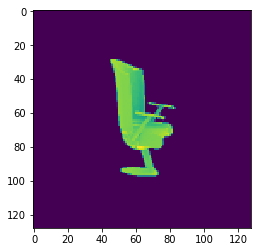

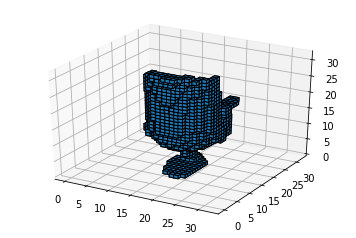

Predicted 3D object
Displaying the object


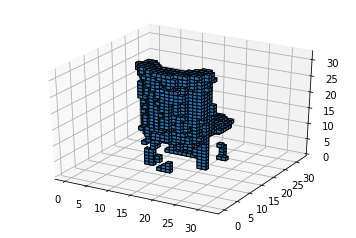

In [21]:
# Generate the 3D Object 
#Testing the general Structure of the VAE
import random
for j in range(0,1):
    i = 98#random.randint(0,99)
    print(i)
    test_image = Variable(torch.FloatTensor(val_images[i])).view(1,1,128,128).cuda()
    print("Real Image")
    plt.imshow(test_image.squeeze().data.cpu().numpy())
    print(test_image.shape)
    test_object,_,_ = vae(test_image)
    test_object = test_object.squeeze().data.cpu().numpy()
    #print("Real 3D voxels")
    print(val_voxels[i].shape)
    display3DObject(Variable(val_voxels[i]).data.cpu().numpy())
    print("Predicted 3D object")
    display3DObject(test_object >0.5)
    

In [19]:
torch.save(vae.state_dict(), 'vae_94.pt')

In [ ]:
#Testing the general Structure of the VAE
test_image = Variable(torch.FloatTensor(images[6])).view(1,1,128,128).cuda()
print(test_image.shape)
vae(test_image)